# Setup

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os
from utils.char_tokenizer import CharTokenizer

In [2]:
config = json.load(open("config.json"))

# Loading data

In [3]:
data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)
data['product_type'] = data['product_type.value']
data = data[['description', 'path', 'product_type', 'label']]
data

,description,path,product_type,label
0,mobile coverb075yysthnamazon brand - solimo de...,d1/d1092873.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07t6v3t9samazon brand - solimo de...,25/25c3cc65.jpg,SOFA,0
2,mobile coverb081hncfc3amazon brand - solimo de...,5a/5a18d1b1.jpg,CELLULAR_PHONE_CASE,1
3,pinzonb07k97dsjxamazon brand - the fix women's...,bf/bf853367.jpg,CELLULAR_PHONE_CASE,0
4,mobile coverb0853wz9vvamazon brand - solimo de...,c1/c1820404.jpg,BEAUTY,0
...,...,...,...,...
157051,back coverb07tg4894famazon brand - symbol men'...,08/0836e89c.jpg,CELLULAR_PHONE_CASE,0
157052,bed;gift;tent;plushie;hands;foam;year;figures;...,2b/2b762611.jpg,HOME_FURNITURE_AND_DECOR,0
157053,samsung galaxy m31 mobile caseb085119c3mamazon...,61/61677d34.jpg,CELLULAR_PHONE_CASE,1
157054,luminaidb07x2tgp2mamazon brand - solimo design...,a9/a981baf8.jpg,CELLULAR_PHONE_CASE,0


In [4]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [5]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(157056, 1014)

## Create embedding weights

In [6]:
weights = tk.create_embedding_weights()
weights.shape

(3202, 3201)

# Image processing

## Load image model

In [7]:
from utils import img_models

In [8]:
img_model = img_models.load(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [ ]:
img = img_models.create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"))

In [ ]:
img.shape

(157056, 576)

# Save embeddings

In [10]:
save_path = os.path.join(config["data"]["path"], "embeddings")

In [ ]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [11]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,description2,path,product_type,label
0,mobile coverb075yysthnamazon brand - solimo de...,"mobile coverb08563mwp6365 everyday value, psyl...",d1/d1092873.jpg,CELLULAR_PHONE_CASE,0
1,mobile coverb07t6v3t9samazon brand - solimo de...,meal kitsb0748r4spcamazon brand - solimo desig...,25/25c3cc65.jpg,SOFA,0
2,mobile coverb081hncfc3amazon brand - solimo de...,mobile coverb081hncfc3amazon brand - solimo de...,5a/5a18d1b1.jpg,CELLULAR_PHONE_CASE,1
3,pinzonb07k97dsjxamazon brand - the fix women's...,air freshener for bathroomb07ydqrzkfamazon bra...,bf/bf853367.jpg,CELLULAR_PHONE_CASE,0
4,mobile coverb0853wz9vvamazon brand - solimo de...,shoesb00r7neg2qamazon-merk: solimo - sun – aft...,c1/c1820404.jpg,BEAUTY,0
...,...,...,...,...,...
157051,back coverb07tg4894famazon brand - symbol men'...,expandingb074mgjzy9amazon brand - solimo desig...,08/0836e89c.jpg,CELLULAR_PHONE_CASE,0
157052,bed;gift;tent;plushie;hands;foam;year;figures;...,mobile coverb08dxd2qcv[amazonブランド] umi.(ウミ)窓用ガ...,2b/2b762611.jpg,HOME_FURNITURE_AND_DECOR,0
157053,samsung galaxy m31 mobile caseb085119c3mamazon...,samsung galaxy m31 mobile caseb085119c3mamazon...,61/61677d34.jpg,CELLULAR_PHONE_CASE,1
157054,luminaidb07x2tgp2mamazon brand - solimo design...,back coverb07tc4plxmwickedly prime organic spr...,a9/a981baf8.jpg,CELLULAR_PHONE_CASE,0


In [12]:
img = np.load(f"{save_path}/img.npy")
img.shape

(157056, 576)

In [13]:
text = np.load(f"{save_path}/text.npy")
text.shape

(157056, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [14]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > 1]

In [15]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=0.1, random_state=42)

In [18]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [19]:
from models.char_cnn_zhang import CharCNNZhang

In [20]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fully_connected_layers": config["char_cnn_zhang"]["fully_connected_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [21]:
# txt_model = CharCNNZhang(**char_cnn_config)

# Load MNN-EM Model

In [22]:
from models.mnn_em import MNNEM

In [23]:
mnn_em = MNNEM(img_input_size=img_model.layers[-1].output_shape[1],
              img_conv_layers=config["mnn_em"]["img_conv_layers"],
              txt_input_size=config["data"]["input_size"],
              txt_conv_layers=config["mnn_em"]["txt_conv_layers"],
              txt_weights=weights,
              char_cnn_config=char_cnn_config,
              combined_conv_layers=config["mnn_em"]["combined_conv_layers"],
              learning_rate=config["mnn_em"]["training"]["learning_rate"]
              )

In [24]:
mnn_em.model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Character_Level_CNN (Functiona  (None, 2048)        29295234    ['Text_Input[0][0]']             
 l)                                                                                               
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| sent_input (InputLayer)      [(None, 1014)]       0           []                            

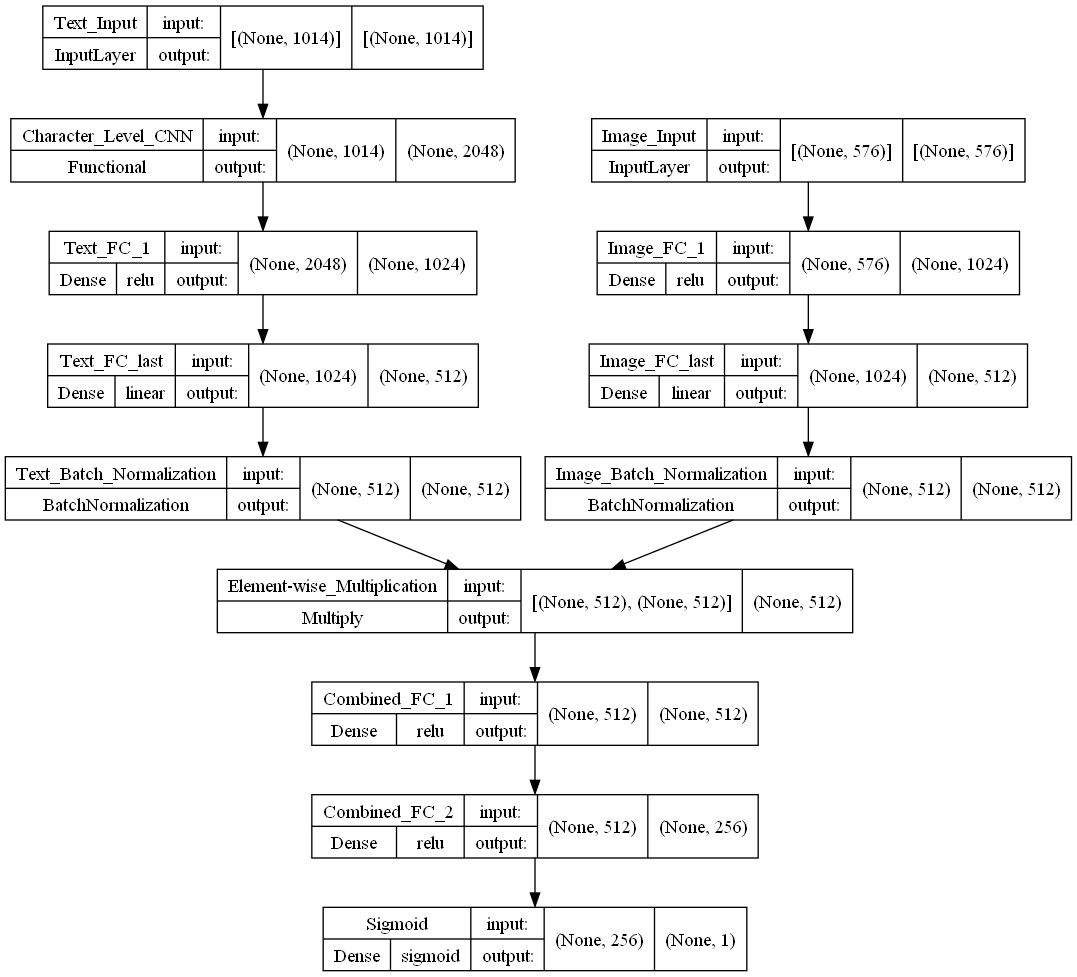

In [25]:
tf.keras.utils.plot_model(mnn_em.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

# Callbacks

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [31]:
model_name = config["mnn_em"]["name"]
optimizer_name = config["mnn_em"]["training"]["optimizer"]
learning_rate = config["mnn_em"]["training"]["learning_rate"]

In [32]:
callback = [
    EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=10,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=False
    ),
    ModelCheckpoint(
        f"./runs/models/{model_name}/{img_model.name}/{optimizer_name}/lr_{learning_rate}",
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    TensorBoard(
        log_dir=f'./runs/logs/{model_name}/{img_model.name}/{optimizer_name}/lr_{learning_rate}',
        histogram_freq=0,
        write_graph=True,
        write_images=False,
        write_steps_per_second=False,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0,
        embeddings_metadata=None,
    )
]

# Training

In [ ]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["mnn_em"]["training"]["epochs"],
    validation_split=config["mnn_em"]["training"]["validation_split"],
    batch_size=config["mnn_em"]["training"]["batch_size"], 
callbacks=callback)
